# Laboratory Automation Control System

# 🧪 Demo of Intelligent Microscope Experiment Automation System

This Notebook demonstrates a **closed-loop experiment automation system** based on Large Language Models (LLMs) and Vision-Language Models (VLMs), with support for:
- Natural language instruction parsing (e.g., "Capture an image of cells")
- Cross-platform collaborative execution (microscope control, Cellpose segmentation, ImageJ analysis)
- Automated result validation and intelligent retry (using VLMs to detect image quality issues)
- Voice-style feedback and execution summaries

## 📂 Overall Architecture

1. **Environment Preparation**  
   Load dependencies, configure APIs, suppress redundant logs, and initialize global tools.

2. **Core Function Definition**  
   - **Auxiliary Summary Function**: Convert robotic actions into natural language feedback.  
   - **Execution-Validation Pipeline**: Implement an intelligent closed loop of "Execute → Check → Correct → Retry".

3. **System Lifecycle Management**  
   Provide complete control interfaces for initialization, microscope configuration, resource release, and more.

## 🔧 I. Environment Preparation

#### 🧪 Environment Configuration and Dependency Import

This unit completes the following key initialization tasks:
- Disable log file output from `pymmcore` and `bfio` to avoid interfering with the console;
- Import core libraries including computer vision (OpenCV), scientific computing (NumPy), and plotting (Matplotlib);
- Configure the logging system to suppress redundant warnings from third-party libraries (e.g., OpenAI, HTTP clients, etc.);
- Load project-specific custom modules, including experiment planners, executors, inspectors, memory managers, and utility classes;

In [ ]:
import os
os.environ["PYMMCORE_LOG_TO_FILE"] = "0"
os.environ["BFIO_LOG_TO_FILE"] = "0"
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import csv
import datetime
import json

import time
import logging

noisy_loggers = [
    "pymmcore_plus",
    "bfio",
    "openai",
    "httpx",
    "httpcore",
    "urllib3",
]

for name in noisy_loggers:
    logging.getLogger(name).setLevel(logging.WARNING)
from openai import OpenAI

from agent.experiment_planner import ExperimentPlanAgent
from utils.memory_manager import HistoryManager,StorageManager
from agent.experiment_executor import ExperimentExecuteAgent
from agent.experiment_checker import ExperimentCheckAgent
from config.agent_config import cfg_tabletop, openai_api_key, base_url,model_name, vlm_api_key, vlm_base_url
from core_tool.tool_utils import SayCapture
from core_tool.cellpose_tool import Cellpose2D
from core_tool.fiji import ImageJProcessor
from core_tool.microscope import MicroscopeController
from config.task_config import OUTPUT_DIR, MAX_RETRY_TIMES, RETRY_INTERVAL, HISTORY_DIR
from config.system_config import CONFIG_PATH, MM_DIR

e:\anconda\envs\llmm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### ⚙️ Configuration Description (`config/` Directory)
This project relies on multiple configuration files (e.g., `agent_config.py`, `system_config.py`, `task_config.py`) to define:

- Large model API access parameters (LLM/VLM)
- Microscope hardware parameters (objectives, channels, device names, travel ranges)
- Image processing paths (Fiji, PSF files, model weights)
- Task control strategies (retry counts, output directories, etc.)

#### 🔒 Important Note
The configuration content shown in the following code blocks is actually stored in independent Python configuration files, and the current Notebook only references them via `import`.
Before running the project for the first time, you **must** fill in all blank paths and keys according to your environment!

In [ ]:
# # # Import prompts (placeholder for demonstration)
# from prompts.ansis_platform_prompt_full import prompt_imagej
# from prompts.cell_seg_prompt_full import prompt_cellpose
# from prompts.micro_control_prompt_full import prompt_olympus
# from prompts.task_manager_full import prompt_manger
# from prompts.fgen import prompt_fgen
# from prompts.prompt_check import prompt_no_target, prompt_over_exposed, prompt_out_of_focus, instruction_prompt_without_no_target, instruction_prompt_with_no_target

# # # -------------------------- LLM Basic Configuration (placeholder) --------------------------
# # OpenAI compatible API configuration
# openai_api_key = '${YOUR_OPENAI_COMPATIBLE_API_KEY}'  # Replace with your OpenAI compatible API key
# base_url = "${YOUR_OPENAI_COMPATIBLE_BASE_URL}"       # Replace with your OpenAI compatible API base URL
# model_name = '${YOUR_LLM_MODEL_NAME}'                 # Replace with your Large Language Model name

# # Multimodal Model (VLM) configuration
# vlm_api_key = "${YOUR_VLM_API_KEY}"                   # Replace with your Vision Language Model API key
# vlm_base_url = "${YOUR_VLM_BASE_URL}"                 # Replace with your Vision Language Model API base URL
# vlm_model_name = "${YOUR_VLM_MODEL_NAME}"             # Replace with your Vision Language Model name

# # Cross-encoder model path
# cross_encoder_model_path = r'${YOUR_CROSS_ENCODER_MODEL_PATH}'  # Replace with your cross-encoder model path

# # Task similarity threshold
# task_similarity_threshold = 0.17

# # # -------------------------- Core Configuration Table (maintain structure, only replace model name placeholders) --------------------------
# cfg_tabletop = {
#     'lmps': {
#         'Task_manger': {
#             'prompt_text': prompt_manger,
#             'engine': '${YOUR_LLM_MODEL_NAME}',
#             'max_tokens': 5120,
#             'temperature': 0,
#             'query_prefix': '# ',
#             'query_suffix': '.',
#             'stop': '#',
#             'maintain_session': True,
#             'debug_mode': False,
#             'include_context': True,
#             'has_return': False,
#             'return_val_name': 'ret_val',
#         },
#         'prompt_olympus': {
#             'prompt_text': prompt_olympus,
#             'engine': '${YOUR_LLM_MODEL_NAME}',
#             'max_tokens': 5120,
#             'temperature': 0,
#             'query_prefix': '#',
#             'query_suffix': '.',
#             'stop': [],
#             'maintain_session': False,
#             'debug_mode': False,
#             'include_context': True,
#             'has_return': False,
#             'return_val_name': 'ret_val',
#         },
#         'prompt_imagej': {
#             'prompt_text': prompt_imagej,
#             'engine': '${YOUR_LLM_MODEL_NAME}',
#             'max_tokens': 5120,
#             'temperature': 0,
#             'query_prefix': '#',
#             'query_suffix': '.',
#             'stop': [],
#             'maintain_session': False,
#             'debug_mode': False,
#             'include_context': True,
#             'has_return': False,
#             'return_val_name': 'ret_val',
#         },
#         'prompt_cellpose': {
#             'prompt_text': prompt_cellpose,
#             'engine': '${YOUR_LLM_MODEL_NAME}',
#             'max_tokens': 5120,
#             'temperature': 0,
#             'query_prefix': '#',
#             'query_suffix': '.',
#             'stop': [],
#             'maintain_session': False,
#             'debug_mode': False,
#             'include_context': True,
#             'has_return': False,
#             'return_val_name': 'ret_val',
#         },
#         'fgen': {
#             'prompt_text': prompt_fgen,
#             'engine': '${YOUR_LLM_MODEL_NAME}',
#             'max_tokens': 1024,
#             'temperature': 0,
#             'query_prefix': '# define function: ',
#             'query_suffix': '.',
#             'stop': [],
#             'maintain_session': False,
#             'debug_mode': False,
#             'include_context': True,
#         },
#         'checker': {
#             'prompt_no_target': prompt_no_target,
#             'prompt_over_exposed': prompt_over_exposed,
#             'prompt_out_of_focus': prompt_out_of_focus,
#             'instruction_prompt_with_no_target':instruction_prompt_with_no_target,
#             'instruction_prompt_without_no_target':instruction_prompt_without_no_target,
#             'engine': '${YOUR_LLM_MODEL_NAME}',
#             'vlm_engine': '${YOUR_VLM_MODEL_NAME}',
#             'max_tokens': 1024,
#             'temperature': 0,
#             'vlm_max_tokens': 1024,
#             'vlm_temperature': 0,
#             'query_prefix': '# define function: ',
#             'query_suffix': '.',
#             'stop': [],
#             'maintain_session': False,
#             'debug_mode': False,
#             'include_context': True,
#         }
#     }
# }

In [ ]:
# # ===================== Microscope Hardware Control Configuration =====================

# # Micro-Manager main program directory (MANDATORY! Must be filled in)
# # Example (Windows): r"C:\Program Files\Micro-Manager-2.0"
# # Example (Linux)  : "/opt/micro-manager"
# MM_DIR = r"${YOUR_MICROMANAGER_DIRECTORY}"  

# # Micro-Manager microscope device configuration file path (.cfg file, MANDATORY! Must be filled in)
# # This file defines hardware devices such as camera, objective turret, filter wheel, etc.
# # Example: r"D:\configs\OlympusIX83.cfg"
# CONFIG_PATH = r"${YOUR_MICROMANAGER_CONFIG_FILE_PATH}"


# # Objective lens label to magnification mapping (KEY NAMES MUST MATCH THE OBJECTIVE DEVICE OPTIONS IN CONFIG_PATH EXACTLY!)
# # Format: 'Objective name displayed in device': magnification
# objective_labels = {
#     '1-UPLFLN4XPH': 4,      # 4× objective lens
#     '2-SOB': 10,            # 10× objective lens
#     '3-LUCPLFLN20XRC': 20,  # 20× objective lens
#     '4-LUCPLFLN40X': 40,    # 40× objective lens
#     '5-LUCPLFLN60X': 60,    # 60× objective lens
#     '6-UPLSAPO30XS': 30     # 30× objective lens (water immersion)
# }


# # Fluorescent dichroic/filter label to corresponding RGB color mapping
# # Used for color assignment when generating RGB composite images later
# # Format: 'Channel name displayed in device': (R, G, B)
# dichroic_colors = {
#     '1-NONE': (128, 128, 128),   # No fluorescence (grayscale)
#     '2-U-FUNA': (0, 0, 255),     # DAPI (blue)
#     '3-U-FBNA': (0, 255, 0),     # FITC (green)
#     '4-U-FGNA': (255, 0, 0),     # TRITC / Cy3 (red)
# }


# # Device names (MUST MATCH THE DEVICE NAMES CONFIGURED IN Micro-Manager IN CONFIG_PATH EXACTLY!)
# # You can view the "Device Name" of each component in Micro-Manager's "Devices" window
# camera_device = '${YOUR_CAMERA_DEVICE_NAME}'                # Camera device name
# xy_stage_device = '${YOUR_XY_STAGE_DEVICE_NAME}'            # XY stage device name
# objective_device = '${YOUR_OBJECTIVE_DEVICE_NAME}'          # Objective turret device name
# transmittedIllumination = '${YOUR_TRANSMITTED_ILLUMINATION_DEVICE_NAME}'  # Transmitted light source (brightfield illumination)
# focus_drive = '${YOUR_FOCUS_DRIVE_DEVICE_NAME}'             # Z-axis focus drive
# Dichroic = '${YOUR_DICHROIC_DEVICE_NAME}'                   # Filter wheel device name


# # Physical travel range of stage and focus axis (Unit: micrometers μm)
# # Used for safety boundary checking to prevent out-of-bounds operations (e.g., crashing into slides)
# # It is recommended to fill in according to the microscope manual, default values can be retained for the first time
# Max_X_position: float = ${YOUR_MAX_X_POSITION}
# Min_X_position: float = ${YOUR_MIN_X_POSITION}
# Max_Y_position: float = ${YOUR_MAX_Y_POSITION}
# Min_Y_position: float = ${YOUR_MIN_Y_POSITION}
# Max_Z_position: float = ${YOUR_MAX_Z_POSITION}   # Maximum Z-axis travel (usually a few millimeters to 1 centimeter)
# Min_Z_position: float = ${YOUR_MIN_Z_POSITION}   # Minimum Z-axis position (avoid crushing slides)


# # Light source and camera parameter range (used for safety limits during automatic adjustment)
# Max_brightness = ${YOUR_MAX_BRIGHTNESS}    # Maximum transmitted light brightness (0–255)
# Min_brightness = ${YOUR_MIN_BRIGHTNESS}
# Max_exposure = ${YOUR_MAX_EXPOSURE}        # Maximum camera exposure time (milliseconds)
# Min_exposure = ${YOUR_MIN_EXPOSURE}


# # ===================== AI Model Path Configuration (Fill in as needed) =====================

# # Tumor region detection model (leave blank to disable)
# TUMOR_MODEL_CONFIG = "${YOUR_TUMOR_MODEL_CONFIG_PATH}"
# TUMOR_MODEL_CHECKPOINT = "${YOUR_TUMOR_MODEL_CHECKPOINT_PATH}"

# # Lesion region detection model
# LESION_MODEL_CONFIG = "${YOUR_LESION_MODEL_CONFIG_PATH}"
# LESION_MODEL_CHECKPOINT = "${YOUR_LESION_MODEL_CHECKPOINT_PATH}"

# # Bacteria detection model
# BACTERIA_MODEL_CONFIG = "${YOUR_BACTERIA_MODEL_CONFIG_PATH}"
# BACTERIA_MODEL_CHECKPOINT = "${YOUR_BACTERIA_MODEL_CHECKPOINT_PATH}"

# # 2D cell segmentation model (e.g., Cellpose custom weights)
# CELL_2D_MODEL_CONFIG = "${YOUR_CELL_2D_MODEL_CONFIG_PATH}"
# CELL_2D_MODEL_CHECKPOINT = "${YOUR_CELL_2D_MODEL_CHECKPOINT_PATH}"

# # Organoid detection model
# ORGANOID_MODEL_CONFIG = "${YOUR_ORGANOID_MODEL_CONFIG_PATH}"
# ORGANOID_MODEL_CHECKPOINT = "${YOUR_ORGANOID_MODEL_CHECKPOINT_PATH}"


# # ===================== Image Processing Dependency Paths =====================

# # Fiji/ImageJ installation path (MANDATORY! Must be filled in)
# # Windows example: r"E:\Imagej\fiji-win64\Fiji.app"
# # macOS example  : "/Applications/Fiji.app"
# # Linux example  : "/opt/fiji/Fiji.app"
# FIJI_PATH = r'${YOUR_FIJI_IMAGEJ_INSTALLATION_PATH}'


# # Point Spread Function (PSF) file path (used for Richardson-Lucy deconvolution, optional but recommended)
# # Should be a 3D PSF image in .tif format, matching the objective lens
# PSF_40X = r"${YOUR_PSF_40X_FILE_PATH}"   # PSF corresponding to 40× objective lens
# PSF_60X = r"${YOUR_PSF_60X_FILE_PATH}"   # PSF corresponding to 60× objective lens
# PSF_100X = r"${YOUR_PSF_100X_FILE_PATH}" # PSF corresponding to 100× objective lens

In [ ]:
# # ===================== Task Execution and Storage Configuration =====================

# # History record storage directory (used to save conversation history, Agent decision logs, etc.)
# # Supports relative or absolute paths. If the directory does not exist, the system will create it automatically.
# # Example: r"./history" or r"D:\experiments\run_20260121\history"
# HISTORY_DIR = r'${YOUR_HISTORY_STORAGE_DIRECTORY}'  # ← Recommended to modify to a meaningful name, such as 'history' or a folder with timestamp


# # Output result storage directory (used to save images, JSON detection results, processing intermediate files, etc.)
# # All files generated by experiments (e.g., .ome.tif, .json, .tif) will be stored in this directory.
# # Example: r"./output" or r"D:\experiments\run_20260121\output"
# OUTPUT_DIR = r'${YOUR_OUTPUT_STORAGE_DIRECTORY}'  # ← Recommended to use 'output' or a custom path to avoid mixing with code


# # Maximum number of retries (maximum number of times the system will attempt to re-execute the task when image quality inspection fails)
# # For example: if failed due to "no target" or "out of focus", the system can automatically adjust parameters and retry.
# # Recommended value: 2–5. Set to 0 to disable retries (not recommended).
# MAX_RETRY_TIMES = ${YOUR_MAX_RETRY_TIMES}


# # Retry interval (seconds)
# # Waiting time before each retry, used for device stabilization (e.g., pause after stage movement, light source preheating, etc.).
# # Recommended value: 2–5 seconds. Too short may cause the device to be not ready, too long reduces efficiency.
# RETRY_INTERVAL = ${YOUR_RETRY_INTERVAL}  # Unit: seconds

## 📝 II. Core Function Definition

### Function Overview

    Encapsulate all core business logic, including functions for LLM summary tools, system initialization, microscope control, task execution, result verification, resource release, and more.

#### 📝 Intelligent Language Model-Assisted Summary Tool


Define three summary functions based on Large Language Models (LLMs) to improve the readability of human-machine interaction:
- `summarize_spoken_messages`: Condense robot voice output (third-person perspective) into concise descriptions;
- `summarize_my_spoken_messages`: Summarize operational intentions from a first-person perspective to enhance user immersion;
- `summarize_task_execution`: Combine the user's original instructions with actual execution steps to generate a professional and objective task execution report, accompanied by guiding questions.

In [2]:
def summarize_spoken_messages(client, spoken_messages):
    if not spoken_messages:
        return "(No spoken output)"

    messages_text = "\n".join(f"- {msg}" for msg in spoken_messages)
    prompt = f"""Summarize the following robot spoken messages into one or two concise and coherent English sentences. Use third-person perspective and do not add any information beyond what is provided:
{messages_text}
"""

    response = client.chat.completions.create(
        model=model_name,
        messages=[
            {"role": "system", "content": "You are an objective observer tasked with summarizing the robot's verbal behavior."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.3,
        max_tokens=150
    )
    return response.choices[0].message.content.strip()

def summarize_my_spoken_messages(client, spoken_messages):
    if not spoken_messages:
        return "(No spoken output)"

    messages_text = "\n".join(f"- {msg}" for msg in spoken_messages)
    prompt = f"""Summarize the following spoken messages into one or two concise and coherent English sentences, as if you are the speaker describing your own actions or intentions. Use first-person perspective (e.g., 'I will...', 'I am...') and do not add any information beyond what is provided:
{messages_text}
"""

    response = client.chat.completions.create(
        model=model_name,
        messages=[
            {"role": "system", "content": "You are summarizing your own spoken messages from a first-person perspective."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.3,
        max_tokens=150
    )
    return response.choices[0].message.content.strip()


def summarize_task_execution(client, user_command: str, lmp_steps: list) -> str:
    """
    Use an LLM to summarize the user's command and the execution steps.
    """
    if not lmp_steps:
        step_desc = "(No execution steps)"
    else:
        steps = []
        for step in lmp_steps:
            idx = step.get('subtask_index', '?')
            module = step.get('module', 'Unknown')
            cmd = step.get('command', '').strip()
            steps.append(f"{idx}. [{module}] {cmd}")
        step_desc = "\n".join(steps)

    prompt = f"""You are an intelligent lab assistant. Generate a concise English summary of the task execution based on the following information:

    User's original command:
    "{user_command}"

    Actual execution steps:
    {step_desc}

    Summarize the task's implementation process in one or two sentences using third-person, objective tone, and end with a gentle, guiding question about the next step."""

    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "You excel at summarizing experimental workflows with concise and professional language."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.3,
            max_tokens=250
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        return f"[Task summary failed: {str(e)}]"


#### 🔌 Initialize Language Model Clients

Create two OpenAI-compatible API clients:
- `llm_client`: Used for text inference (task planning, summary generation, etc.);
- `vlm_client`: Reserved for Vision-Language Models (VLMs) to support future image understanding tasks.

In [3]:
say_capture = SayCapture()

llm_client = OpenAI(api_key=openai_api_key, base_url=base_url)
vlm_client = OpenAI(api_key=vlm_api_key, base_url=vlm_base_url)


#### 🏗️ Build the Backbone of the Automated Experiment System

The `initialize_system()` function is responsible for assembling the entire intelligent experiment platform:
- Instantiate three core environments: microscope controller (`MicroscopeController`), ImageJ image processor, and Cellpose cell segmenter;
- Register commonly used Python libraries (e.g., `np`, `cv`, `plt`) as global variables for subsequent calls by ExperimentExecuteAgent (Language Model Programs);
- Create a dedicated `ExperimentExecuteAgent` for each functional module to enable modular execution;
- Initialize the task planner (`ExperimentPlanAgent`) and result inspector (`ExperimentCheckAgent`);
- Establish a mapping table (`module_map`) from module names to execution agents to support dynamic routing;
- Clear historical records and caches to ensure each run starts from a clean state.

In [4]:
def initialize_system():
    historymanager = HistoryManager(HISTORY_DIR)
    storageManager = StorageManager(HISTORY_DIR, OUTPUT_DIR)

    try:
        env_olympus = MicroscopeController(CONFIG_PATH, MM_DIR, OUTPUT_DIR, storageManager)
        env_imagej = ImageJProcessor(storageManager, OUTPUT_DIR)
        env_cellpose = Cellpose2D(storageManager, OUTPUT_DIR)
    except Exception as e:
        raise Exception(f"Core environment initialization failed: {str(e)}")

    fixed_vars = {
        'np': np,
        'cv': cv,
        'datetime': datetime,
        'time': time,
        'csv': csv,
        'json': json,
        'plt': plt,
        'say':say_capture.say
    }

    microscope_methods = env_olympus.get_public_methods()
    olympus_vars = {k: getattr(env_olympus, k) for k in microscope_methods if hasattr(env_olympus, k)}
    imagej_methods = env_imagej.get_public_methods()
    imagej_vars = {k: getattr(env_imagej, k) for k in imagej_methods if hasattr(env_imagej, k)}
    cellpose_methods = env_cellpose.get_public_methods()
    cellpose_vars = {k: getattr(env_cellpose, k) for k in cellpose_methods if hasattr(env_cellpose, k)}

    olympus_tool_agent = ExperimentExecuteAgent('prompt_olympus', cfg_tabletop['lmps']['prompt_olympus'], cfg_tabletop['lmps']['fgen'], fixed_vars, olympus_vars, llm_client, historymanager)

    imagej_tool_agent = ExperimentExecuteAgent('prompt_olympus', cfg_tabletop['lmps']['prompt_imagej'], cfg_tabletop['lmps']['fgen'], fixed_vars, imagej_vars, llm_client, historymanager)

    cellpose_tool_agent = ExperimentExecuteAgent('prompt_olympus', cfg_tabletop['lmps']['prompt_cellpose'], cfg_tabletop['lmps']['fgen'], fixed_vars, cellpose_vars, llm_client, historymanager)

    plan_agent = ExperimentPlanAgent(
            'Task_manger',
            cfg_tabletop['lmps']['Task_manger'],
            llm_client,
            historymanager,
            clarify_tag=True
        )
    
    check_agent = ExperimentCheckAgent(cfg_tabletop['lmps']['checker'], llm_client, vlm_client, OUTPUT_DIR)

    module_map = {
        'Microscope Operation Platform': olympus_tool_agent,
        'Cell Segmentation Platform': cellpose_tool_agent,
        'Image Analysis Platform': imagej_tool_agent
    }

    storageManager.clear_all_records()
    historymanager.clear()

    return {
        'env_olympus': env_olympus,
        'env_imagej': env_imagej,
        'env_cellpose': env_cellpose,
        'storageManager': storageManager,
        'historymanager': historymanager,
        'task_manager': plan_agent,
        'module_map': module_map,
        'checker': check_agent 
    }

#### 🔬 Microscope Platform Initialization and Information Configuration

The `setup_microscope()` function sets the default working state of the microscope:
- Initialize hardware connections;
- Switch to the 2× objective lens (`2-SOB`);
- Turn off the fluorescence channel (`1-NONE`);
- Set exposure time, brightness, Z-axis height, and XY center position;
- Activate real-time preview mode.

The `microscope_info()` function retrieves the current key configuration status of the microscope:
- Obtain the microscope's current key configuration status (objective lens, channel, exposure, brightness), return it in dictionary format, and provide hardware context information for user instruction parsing.

In [ ]:
def setup_microscope(env_olympus):
    """Set microscope initial state (optimization: add exception handling + status log output)"""
    try:
        env_olympus.initialize()
        env_olympus.set_objective('2-SOB')
        env_olympus.set_channel('1-NONE')
        env_olympus.set_exposure(10)
        env_olympus.set_brightness(100)
        env_olympus.set_z_position(3500)
        env_olympus.set_x_y_position(50000, 50000)
        # Output current configuration status for troubleshooting
        env_olympus.start_preview()
    except Exception as e:
        raise Exception(f"Microscope initial state configuration failed: {str(e)}")
    
def microscope_info(env_olympus):
        current_state = {
            'objective': env_olympus.get_objective(),
            'channel': env_olympus.get_channel(),
            'exposure': env_olympus.get_exposure(),
            'brightness': env_olympus.get_brightness()
        }
        return current_state

#### 🧠 Execution Function Definition

Encapsulate the workflow through the `process_instruction()`, `run_task()`, `run_task_with_validation()`, and `check_results()` functions.

Implement the workflow of Parsing → Execution → Validation → Retry.

The `process_instruction()` function encapsulates the calling logic of the task planner:
- Receive natural language user commands;
- Parse them into a structured list of LMP steps by `ExperimentPlanAgent`;
- Return the readiness status, execution steps, and the number of tokens consumed.

In [6]:
def process_instruction(task_manager, command, state):
    """Task instruction parsing (optimization: add logs + exception handling)"""
    try:
        ready, LMP_steps, tokens = task_manager.run(command, state)
        return ready, LMP_steps, tokens
    except Exception as e:
        raise Exception(f"Instruction parsing failed: {str(e)}")

The `check_results()` function implements closed-loop validation:
- Read metadata of newly generated images from the cache of the `storageManager` storage manager;
- Call `ExperimentCheckAgent` to conduct batch evaluation of image quality (e.g., blurriness, overexposure, no targets, etc.);
- Automatically distinguish defects such as blurriness, overexposure, and absence of targets, and use LLMs to generate correction instructions for use in the next round of retries;

In [7]:
def check_results(storageManager, original_instruction, original_x_y, checker):
    """Result validation (new checker parameter, using instance created during initialization)"""
    try:
        # Get temporary area files
        meta_file_temp = storageManager.read_cache()
        if not meta_file_temp:
            return True, "", False  # No files = validation failed, no correction instruction, no target exception
        if not any(
            info.get("created_by") == "microscope" and info.get("file_type") == "ome-tiff"
            for info in meta_file_temp.values()
        ):
            return True, "", False
        # Batch validate image results (using passed checker instance instead of global)
        all_results = checker.batch_check_from_json(meta_file_temp)
        task_defect_dict = checker.summarize_task_defects()
        print(f"Result validation completed, defect summary: {task_defect_dict}")
        has_no_target_error = False
        all_images_normal = all(
            "All channels are defect-free" in msg for msg in task_defect_dict.values()
        )
        for defect_desc in task_defect_dict.values():
            if "All channels are defect-free" in defect_desc:
                continue
            if "No target" in defect_desc:
                has_no_target_error = True
                # Batch delete invalid cache files
                cache_filenames = list(meta_file_temp.keys())
                storageManager.batch_delete_files(
                    filenames=cache_filenames,
                    delete_physical=True,
                    remove_meta=True
                )
                break

        # Generate correction instruction (you have confirmed the return list, no additional processing needed)
        unified_instruction = ''
        if not all_images_normal:
            unified_instruction = checker.generate_task_unified_instruction(
                original_x_y,
                original_instruction=original_instruction
            )

        # Clear detector historical results to avoid cumulative interference
        checker.clear_history_results()
        return all_images_normal, unified_instruction, has_no_target_error
    except Exception as e:
        checker.clear_history_results()
        raise Exception(f"Result validation failed: {str(e)}")

The `run_task()` function is responsible for executing experimental steps in sequence:
- Read the meta-information stored in `storageManager` (meta-information of stored files is automatically added when the storage function is run), inject it into the context, and assist submodules in generating code;
- Route to the corresponding execution agent (microscope / ImageJ / Cellpose) based on the module name;
- Capture and summarize robot voice feedback in real time.

In [8]:
def run_task(
        LMP_steps,
        module_map,
        env_olympus,
        storageManager,
):
    try:
        # Clear cache for this execution (context controlled by caller)
        storageManager.clear_cache()

        for step in sorted(LMP_steps, key=lambda x: x['subtask_index']):
            say_capture.clear()
            meta_file = storageManager.read_log(True)
            context = f"# Saved documents:\n {meta_file}"
            module_name = step['module']
            command = step['command']

            if module_name == 'Microscope Operation Platform':
                env_info = (
                    f"Current xy_position:{env_olympus.get_x_y_position()}, "
                    f"z_position:{env_olympus.get_z_position()}, "
                    f"exposure_time:{env_olympus.get_exposure()}, "
                    f"objective:{env_olympus.get_objective()}, "
                    f"dichroic:{env_olympus.get_channel()}, "
                    f"brightness:{env_olympus.get_brightness()}"
                )
                context += f'\n# Current environment:{env_info}'

            if module_name in module_map:
                module_instance = module_map[module_name]
                module_instance.run(command, context)
            else:
                raise ValueError(f"Unknown module: {module_name}")
            spoken_messages = say_capture.get_messages()
            summary = summarize_spoken_messages(llm_client, spoken_messages)
            print(f'[Robot]{summary}')
        return True  # Execution completed

    except Exception as e:
        print(f"❌ Error occurred during task execution: {str(e)}")
        raise  

The `run_task_with_validation()` function provides a high-reliability execution strategy:
- Automatically verify the quality of results after each execution;
- If execution fails but correction instructions exist, replace the original steps with new instructions and retry;
- Submit the cache to persistent storage upon success, or return the final status if failed.

In [9]:
def run_task_with_validation(
    original_LMP_steps,
    module_map,
    env_olympus,
    storageManager,
    checker,
    max_retry_times=MAX_RETRY_TIMES,
    retry_interval=RETRY_INTERVAL
):
    """
    High-level orchestration function: Responsible for the complete process of "execute task -> validate results -> decide retry/correction".
    """
    retry_count = 0
    current_steps = [step.copy() for step in original_LMP_steps]

    while retry_count < max_retry_times:
        retry_count += 1

        try:
            # 1. Execute task (call pure execution function)
            original_x_y = env_olympus.get_x_y_position()
            run_task(
                LMP_steps=current_steps,
                module_map=module_map,
                env_olympus=env_olympus,
                storageManager=storageManager
            )
        except Exception as e:
            if retry_count >= max_retry_times:
                return False, retry_count
            time.sleep(retry_interval)
            current_steps = [step.copy() for step in original_LMP_steps]
            continue

        # 2. Validate results
        all_images_normal, unified_instruction, has_no_target_error = check_results(
            storageManager, original_LMP_steps, original_x_y, checker
        )
        if not all_images_normal:
            print(summarize_my_spoken_messages(llm_client, unified_instruction))
        if all_images_normal:
            storageManager.commit_cache()
            return True, retry_count

        # 3. Decide whether to retry
        if retry_count >= max_retry_times:
            return False, retry_count

        # 4. Prepare next round steps (use correction instruction or fallback to original)
        if unified_instruction and len(unified_instruction) > 0:
            current_steps = [step.copy() for step in unified_instruction]
        else:
            current_steps = [step.copy() for step in original_LMP_steps]

        time.sleep(retry_interval)

    return False, retry_count

#### 🧹 Safely Shut Down System Resources

The `release_resources()` function ensures a graceful exit:
- Call the `shutdown` methods of the microscope and ImageJ to release hardware/software locks;
- Clear temporary cache and historical records to avoid contaminating subsequent runs;
- Include exception protection to prevent crashes during the cleanup process.

In [10]:
def release_resources(system_components):
    """Release system resources"""
    try:
        # Release microscope resources
        env_olympus = system_components.get('env_olympus')
        if env_olympus and hasattr(env_olympus, 'shutdown'):
            env_olympus.shutdown()
        # Release ImageJ resources
        env_imagej = system_components.get('env_imagej')
        if env_imagej and hasattr(env_imagej, 'fiji_shutdown'):
            env_imagej.fiji_shutdown()
        # Clear storage and history
        storageManager = system_components.get('storageManager')
        historymanager = system_components.get('historymanager')
        if storageManager:
            storageManager.clear_cache()
        if historymanager:
            historymanager.clear()
    except Exception as e:
        raise Exception(f"Resource release failed: {str(e)}")

## 📝 III. Real Task Interaction

Run the Initialization Function

In [11]:
system_components = initialize_system()
setup_microscope(system_components['env_olympus'])

e:\anconda\envs\llmm\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


#### 🔬 Task Objective: Real-time Preview of High-magnification Clear Images of Monkey Kidney Cell Sections Under the FITC Fluorescence Channel

**User Instruction**  
> "I'm currently observing monkey kidney cell sections. Please switch to a clear view using the 40x objective under FITC fluorescence."

**System Behavior**  
- Instruction Parsing: Call ExperimentPlanAgent to analyze the natural language instruction, and generate a structured list of subtasks (LMP steps) combined with prompt examples, clarifying the microscope configuration operations to be performed.
- Parameter Configuration and Execution:
    - Switch Objective Lens: Detect that the current objective lens is not 4-LUCPLFLN40X, and automatically switch to the 40× objective lens;
    - Set Fluorescence Channel: Switch the filter cube to FITC mode (Channel 3-U-FBNA);
    - Adjust Imaging Parameters:
    - Set the camera exposure time to 100.0 ms to adapt to the FITC fluorescence signal intensity;
    - Set the transmitted light brightness to 0 (in line with fluorescence imaging specifications to avoid background interference);
    - Autofocus: Call perform_autofocus() to scan the Z-axis, determine the optimal focal plane as 4131.5 μm, and set the Z position;

**Intelligent Feedback**  
- Status Feedback: Each operation outputs structured logs via say() (e.g., [INFO] Objective lens set to 40x...), simulating robot voice feedback;
- Task Summary: After execution is completed, call summarize_task_execution to generate a natural language summary, confirm that all configurations have been successfully applied, and proactively ask the user about their next intention (e.g., whether to take photos or perform scanning).

In [13]:
user_command = "I'm currently observing monkey kidney cell sections. Please switch to a clear view using the 40x objective under FITC fluorescence." 
microscope_state = microscope_info(system_components['env_olympus'])
ready, LMP_steps, tokens = process_instruction(system_components['task_manager'], user_command, microscope_state)
task_success, retry_times = run_task_with_validation(
    original_LMP_steps=LMP_steps,
    module_map=system_components['module_map'],
    env_olympus=system_components['env_olympus'],
    storageManager=system_components['storageManager'],
    checker=system_components['checker']
)
final_summary = summarize_task_execution(
    llm_client,
    user_command=user_command,
    lmp_steps=LMP_steps
)
print(f'[Robot]{final_summary}')

[Robot]I will switch to the 40× objective, configure the microscope for FITC fluorescence imaging, automatically adjust the camera exposure and light settings, then autofocus on the monkey kidney cell section. Shall I start?
[User]execute

===== Executing Code =====
say("[INFO] Starting parameter setup for 40x FITC fluorescence imaging of monkey kidney cell sections")

target_objective = '4-LUCPLFLN40X'
current_objective = get_objective()
if current_objective != target_objective:
    set_objective(target_objective)
    say(f"[INFO] Objective lens set to 40x (label: {target_objective})")
else:
    say(f"[INFO] Objective lens is already 40x (label: {target_objective}), no change needed")

target_channel = '3-U-FBNA'
current_channel = get_channel()
if current_channel != target_channel:
    set_channel(target_channel)
    say(f"[INFO] Filter set to FITC fluorescence mode (channel: {target_channel})")
else:
    say(f"[INFO] Filter is already in FITC fluorescence mode (channel: {target_chann

#### 🗺️ Task Objective: Automatically Scan a 3×3 mm Area Under the FITC (Green) Fluorescence Channel with a 40× Objective Lens

**User Instruction**
> "I need to scan a 3×3 mm area using green fluorescence under the 40× objective."

**System Behavior**
- Instruction Parsing: Call the ExperimentPlanAgent to analyze the natural language instruction and generate a structured list of subtasks (LMP steps).
- Parameter Configuration:
  - Set the fluorescence filter to FITC mode (Channel 3-U-FBNA);
  - Configure the camera exposure time to 100.0 ms to match the FITC signal intensity;
  - Read the current stage position and plan a 3×3 mm scanning grid centered on this position.
- Automated Scanning Execution:
  - Call the automatic stitching imaging function of the microscope platform, move the XY stage according to the preset step size, and capture multiple high-magnification images point by point;
  - Automatically save all sub-images as a single OME-TIFF file: FITC_3x3mm_40x.ome.tif;
  - Output a success log after scanning is completed: [INFO] FITC fluorescence image acquisition for 3×3 mm area completed successfully.
- Result Verification:
  - The system invokes the ExperimentCheckAgent to perform VLM quality assessment on the generated images;
  - Verification Result: "All channels are defect-free", with no blurriness, overexposure or absence of targets;
  - Submit the images to persistent storage and complete cache cleanup.

**Intelligent Feedback**
- The LLM generates a task summary confirming the parameters, position, scanning range and success status;
- Proactively propose a follow-up suggestion: "Would you like to proceed with image stitching and analysis?" to reflect task continuity.

In [14]:
user_command = "I need to scan a 3×3 mm area using green fluorescence under the 40× objective." 
microscope_state = microscope_info(system_components['env_olympus'])
ready, LMP_steps, tokens = process_instruction(system_components['task_manager'], user_command, microscope_state)
task_success, retry_times = run_task_with_validation(
    original_LMP_steps=LMP_steps,
    module_map=system_components['module_map'],
    env_olympus=system_components['env_olympus'],
    storageManager=system_components['storageManager'],
    checker=system_components['checker']
)
final_summary = summarize_task_execution(
    llm_client,
    user_command=user_command,
    lmp_steps=LMP_steps
)
print(f'[Robot]{final_summary}')

[Robot]I will configure the FITC fluorescence channel with 100 ms exposure time and set up automatic image acquisition to scan a 3×3 mm area at the current stage position using the 40× objective. Shall I start?
[User]execute

===== Executing Code =====
say("[INFO] Starting FITC fluorescence image acquisition parameter configuration for 3×3 mm area")

say("[INFO] Configuring FITC fluorescence channel parameters")
target_channel = '3-U-FBNA'
current_channel = get_channel()
if current_channel != target_channel:
    set_channel(target_channel)
    say(f"[INFO] Filter set to FITC fluorescence mode (channel: {target_channel})")
else:
    say(f"[INFO] Filter is already in FITC fluorescence mode (channel: {target_channel}), no change needed")

target_exposure = 100.0
current_exposure = get_exposure()
if current_exposure != target_exposure:
    set_exposure(target_exposure)
    say(f"[INFO] Exposure time set to {target_exposure} ms")
else:
    say(f"[INFO] Exposure time is already {target_expos

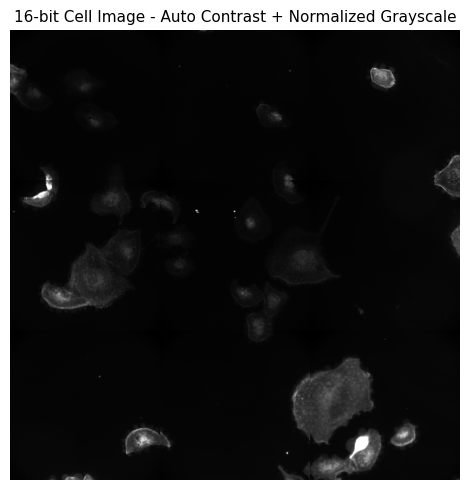

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Image path (optimized for cross-platform compatibility)
target_image_path = r"output\FITC_3x3mm_40x.ome.tif"

# Load the OME-TIFF image and convert to numpy array
target_image = np.array(Image.open(target_image_path))

# Percentile thresholds for contrast enhancement
low_percentile = 0.1    # Low percentile to filter extreme dark pixels
high_percentile = 99.9  # High percentile to filter extreme bright pixels

# Calculate pixel values at the specified percentiles
img_low = np.percentile(target_image, low_percentile)
img_high = np.percentile(target_image, high_percentile)

# Clamp pixel values: restrict pixels to the range [img_low, img_high]
img_contrast_adjusted = np.clip(target_image, img_low, img_high)

# Step 2: Normalize pixel values to the range [0, 1] (based on adjusted contrast range)
img_min_adjusted = np.min(img_contrast_adjusted)
img_max_adjusted = np.max(img_contrast_adjusted)

# Prevent division by zero (error handling for uniform pixel intensity)
if img_max_adjusted - img_min_adjusted == 0:
    img_normalized = target_image.astype(np.float32) / 65535.0
else:
    # Convert to float32 for calculation precision to avoid 16-bit integer overflow
    img_normalized = (img_contrast_adjusted - img_min_adjusted).astype(np.float32) / (img_max_adjusted - img_min_adjusted)

# Display the contrast-enhanced grayscale image (specify cmap='gray' for grayscale rendering)
plt.figure(figsize=(6, 5))
plt.imshow(img_normalized, cmap='gray')
plt.title("16-bit Cell Image - Auto Contrast + Normalized Grayscale", fontsize=11)
plt.axis('off')

plt.tight_layout()
plt.show()

#### 🎯 Task Objective: Automatically Detect Positions of Monkey Kidney Cell Sections in the Acquired 3×3 mm Fluorescence Image

**User Instruction**
> "Detect all monkey kidney cell section positions in the acquired image."

**System Behavior**
- The ExperimentPlanAgent identifies this as an image analysis task with the following objectives:
  - Input: The recently acquired FITC fluorescence image (FITC_3x3mm_40x.ome.tif);
  - Operation: Detect the positions of all suspected two-dimensional regions of "monkey kidney cell sections" in the image;
  - Output: Structured detection results (e.g., coordinates, bounding boxes, etc.) and save them as a file.
- Execution Process:
  - Launch the ImageJ/Fiji environment: Call fiji_initialize() to initialize the image analysis platform;
  - Load the image: Read the FITC_3x3mm_40x.ome.tif file generated by the previous scanning step;
  - Call analysis_platform_find_2Dcell_position(), a function encapsulating a pre-trained model for target detection;
  - Save the results: Persistently store the detected cell region information (e.g., center coordinates, contours) in JSON format;
- Release Resources: Call fiji_shutdown() to close the ImageJ process and avoid memory leaks.

**Feedback and Summary**:
  - Output operation logs in real time (e.g., [ACTION] Loading..., [ACTION] Detecting...);
  - After task completion, the LLM generates a summary specifying the following:
  Source of the input image (3×3 mm, 40×, FITC);
  Operation performed (automatic 2D cell region detection);
  Output format (JSON file);
  - Proactively suggest the next step: "Would you like to analyze the detection results or perform further processing on the identified regions?"

In [15]:
user_command = "Detect all monkey kidney cell section positions in the acquired image." 
microscope_state = microscope_info(system_components['env_olympus'])
ready, LMP_steps, tokens = process_instruction(system_components['task_manager'], user_command, microscope_state)
task_success, retry_times = run_task_with_validation(
    original_LMP_steps=LMP_steps,
    module_map=system_components['module_map'],
    env_olympus=system_components['env_olympus'],
    storageManager=system_components['storageManager'],
    checker=system_components['checker']
)
final_summary = summarize_task_execution(
    llm_client,
    user_command=user_command,
    lmp_steps=LMP_steps
)
print(f'[Robot]{final_summary}')

[Robot]I will import the FITC fluorescence image of the monkey kidney cell sections and detect regions that appear to be cells, then save those detection results to a file. Shall I start?
[User]execute

===== Executing Code =====
fiji_initialize()
input_file = "FITC_3x3mm_40x.ome.tif"
say("[ACTION] Loading 40× magnified FITC fluorescence image of monkey kidney cell sections: " + input_file)
image = load_image(input_file)
say("[ACTION] Detecting suspected 2D cell regions in the FITC fluorescence image")
detection_result = analysis_platform_find_2Dcell_position(image, "Suspected 2D cell regions detected in 40× FITC fluorescence image of 3mm×3mm monkey kidney cell sections")
say("[INFO] Detection results saved as JSON file")
fiji_shutdown()


===== Execution Process =====
[Robot action] [ACTION] Loading 40× magnified FITC fluorescence image of monkey kidney cell sections: FITC_3x3mm_40x.ome.tif
[Robot action] [ACTION] Detecting suspected 2D cell regions in the FITC fluorescence image
[Rob

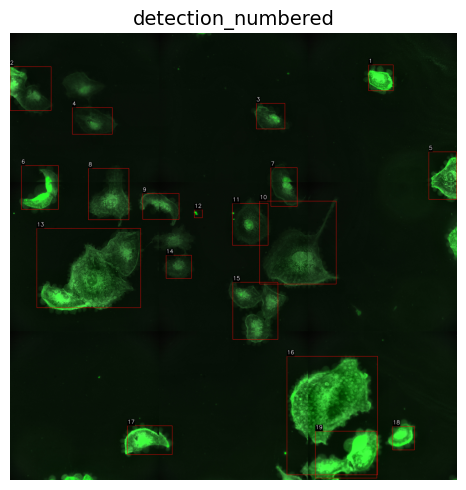

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Keep only the path to the single image to be displayed
target_image_path = "output\detection_numbered.jpg"

# Read the image and convert to numpy array (resolve PIL image imshow compatibility issues)
target_image = np.array(Image.open(target_image_path))

# Display the single image directly (no need to create multiple subplots)
plt.figure(figsize=(6, 5))  # Set image display size (adjust as needed)
plt.imshow(target_image)
plt.title("detection_numbered", fontsize=14)  # Set image title
plt.axis('off')  # Turn off axis for cleaner visualization

plt.tight_layout()
plt.show()

#### 🎯 Task Objective: Acquire DAPI/FITC/TRITC Three-channel Fluorescence Images of Cell 4 and Cell 13 Respectively Using a 60× Objective Lens

**User Instruction**
> "Use the 60× objective to acquire multi-fluorescence-channel images of Cell 4 and Cell 13, respectively."

**System Behavior**
- Interactive Intention Clarification (Clarification Loop)

  Since the original instruction does not specify key parameters, the system proactively initiates multiple rounds of clarification:
  - Clarification 1: Confirm the required fluorescence channels → User reply: DAPI, FITC and TRITC;
  - Clarification 2: Confirm the focusing strategy (re-focusing is required after switching the objective lens) → User specification: Perform focusing on each of the two cells using the FITC channel;
  - Clarification 3: Confirm the exposure time for each channel → User sets a unified exposure time of 100 ms for all channels.

- Automated Execution Process
  - Switch Objective Lens: Switch from the current objective lens (e.g., 40×) to the 60× objective lens (5-LUCPLFLN60X);
  - Load Cell Positions: Read the coordinates of Cell 4 and Cell 13 from the detection results of the previous step (JSON file);
  - Image Acquisition for Each Cell (repeat the following steps for each cell):
    - Move the stage to the target cell position;
    - Perform autofocus using the FITC channel (only once, in accordance with the optical rule that "re-focusing is not required when switching fluorescence channels");
    - Switch to the DAPI → FITC → TRITC channels in sequence, acquire images with 100 ms exposure for each channel;
    - Merge the three-channel images and save them as a single OME-TIFF file (e.g., Cell_4.ome.tif);
  - Result Verification:
    - Call the ExperimentCheckAgent to conduct VLM quality inspection on the two images;
    - Verification Result: Both images are "defect-free" (no target loss, no defocusing, no overexposure);
  - Resource Cleanup: Release temporary cache and submit valid files.

**Intelligent Feedback and Guidance**
- Pre-execution Summary: Clearly state that the system will "switch to 60× objective lens, locate the cells, and acquire three-channel images after focusing";
- Post-execution Summary: The LLM generates a professional description covering the objective lens, cell positioning, focusing strategy, channel configuration, and exposure parameters;
- Proactively Suggest the Next Step: "Would you like to analyze these images or acquire images of more cells?" to support experimental continuity.

In [16]:
user_command = "Use the 60× objective to acquire multi-fluorescence-channel images of Cell 4 and Cell 13, respectively." 
microscope_state = microscope_info(system_components['env_olympus'])
ready, LMP_steps, tokens = process_instruction(system_components['task_manager'], user_command, microscope_state)
task_success, retry_times = run_task_with_validation(
    original_LMP_steps=LMP_steps,
    module_map=system_components['module_map'],
    env_olympus=system_components['env_olympus'],
    storageManager=system_components['storageManager'],
    checker=system_components['checker']
)
final_summary = summarize_task_execution(
    llm_client,
    user_command=user_command,
    lmp_steps=LMP_steps
)
print(f'[Robot]{final_summary}')


[Robot] You want to acquire multi-fluorescence-channel images of Cell 4 and Cell 13 using the 60× objective. Which specific fluorescence channels do you need (e.g., DAPI, FITC, TRITC, or others), and what exposure times should be used for each channel?

[User]DAPI, FITC and TRITC

[Robot] After changing from the 40× to 60× objective, the plans perform focusing only once for Cell 4 (using FITC channel) before capturing all three channels (DAPI, FITC, TRITC). According to the rules, switching fluorescence channels does not require refocusing. However, should the system use the FITC channel for initial focusing, or would you prefer a different channel (such as DAPI or TRITC) for the focusing operation?

[User]Focus on the two cells using the FITC channel.

[Robot] All three plans configure exposure times differently for the DAPI, FITC, and TRITC channels. Should the system use the same automatically configured exposure time for all three channels, or do you need different exposure times 

#### 🖼️ Task Objective: Perform a Complete Post-processing Pipeline on the Three-channel Fluorescence Images of Cell 4 and Cell 13

**User Instruction**
> "For both Cell 4 and Cell 13, first generate a raw RGB merge from the original channels, then apply Richardson-Lucy deconvolution to each channel separately, perform automatic contrast adjustment on the deconvolved channels, and finally create an enhanced RGB merge…"

**System Behavior**
- Task Parsing and Planning

  The ExperimentPlanAgent decomposes the complex instruction into structured, sequence-sensitive subtasks:
  - Input: Existing Cell_4.ome.tif and Cell_13.ome.tif (containing DAPI/FITC/TRITC three channels);
  - Processing Pipeline (executed independently for each cell):
    - Generate a raw RGB merge image;
    - Perform Richardson-Lucy deconvolution (deblurring) on each channel separately;
    - Perform automatic contrast adjustment on the deconvolved channels;
    - Generate a final enhanced RGB merge image using the processed channels.

- Automated Execution Process
  - Initialize the ImageJ/Fiji environment: Call fiji_initialize();
  - Process Each Cell Separately (take Cell 4 as an example, Cell 13 follows the same procedure):
    - Load the image: Read Cell_4.ome.tif;
    - Split channels: Split into DAPI (Channel 0), FITC (Channel 1), and TRITC (Channel 2);
    - Generate raw RGB merge image:
      Call merge_channels(..., colors=["Blue", "Green", "Red"]) → Save as Cell_4_raw_rgb.tif;
    - Deconvolution Processing:
      Call richardson_lucy(..., magnification=60, iterations=10) for each channel, output as files such as Cell_4_DAPI_deconv.tif;
    - Contrast Enhancement: Perform automatic contrast adjustment on each deconvolved channel;
    - Generate enhanced RGB merge image: Merge the processed three channels → Output the final result (e.g., Cell_4_enhanced_rgb.tif);
  - Resource Cleanup: Call fiji_shutdown() after the task is completed.
  - All intermediate files (raw merge, deconvolved channels, enhanced merge) are explicitly named and saved for easy traceability and verification.

**Result Verification and Feedback**
- Execution Logs: Each step outputs logs at [ACTION] or [INFO] level to clearly display the processing status;
- Task Summary: The LLM accurately summarizes the complete workflow of "Loading → Splitting → Deconvolution → Contrast Adjustment → Merging";
- Intelligent Guidance: Proactively suggest the next step — "Would you like to compare the raw and enhanced images or perform other processing?" to support in-depth analysis.

In [17]:
user_command = "For both Cell 4 and Cell 13, first generate a raw RGB merge from the original channels, then apply Richardson-Lucy deconvolution to each channel separately, perform automatic contrast adjustment on the deconvolved channels, and finally create an enhanced RGB merge from the contrast-adjusted, deconvolved channels." 
microscope_state = microscope_info(system_components['env_olympus'])
ready, LMP_steps, tokens = process_instruction(system_components['task_manager'], user_command, microscope_state)
task_success, retry_times = run_task_with_validation(
    original_LMP_steps=LMP_steps,
    module_map=system_components['module_map'],
    env_olympus=system_components['env_olympus'],
    storageManager=system_components['storageManager'],
    checker=system_components['checker']
)
final_summary = summarize_task_execution(
    llm_client,
    user_command=user_command,
    lmp_steps=LMP_steps
)
print(f'[Robot]{final_summary}')

[Robot]I will import and process the fluorescence images for Cell 4 and Cell 13 by merging their color channels, applying deconvolution to sharpen each channel, adjusting contrast, and creating enhanced composite images for both cells. Ready to proceed?
[User]execute

===== Executing Code =====
fiji_initialize()

# Process Cell 4
input_file_cell4 = "Cell_4.ome.tif"
say("[ACTION] Loading Cell 4 multi-channel fluorescence image: " + input_file_cell4)
image_cell4 = load_image(input_file_cell4)

say("[ACTION] Splitting Cell 4 into individual channels (DAPI, FITC, TRITC)")
channels_cell4 = split_channels(image_cell4)
dapi_cell4 = channels_cell4[0]
fitc_cell4 = channels_cell4[1]
tritc_cell4 = channels_cell4[2]

say("[ACTION] Merging raw Cell 4 channels into RGB composite image")
raw_rgb_cell4 = merge_channels([dapi_cell4, fitc_cell4, tritc_cell4], colors=["Blue", "Green", "Red"], outpath="Cell_4_raw_rgb.tif")

say("[ACTION] Applying Richardson-Lucy deconvolution to DAPI channel of Cell 4")
d

> **Note**: The following operations are manual auxiliary analyses, which are used to understand the changes of images during the image processing step by step and are **not part of the system's automated workflow**.

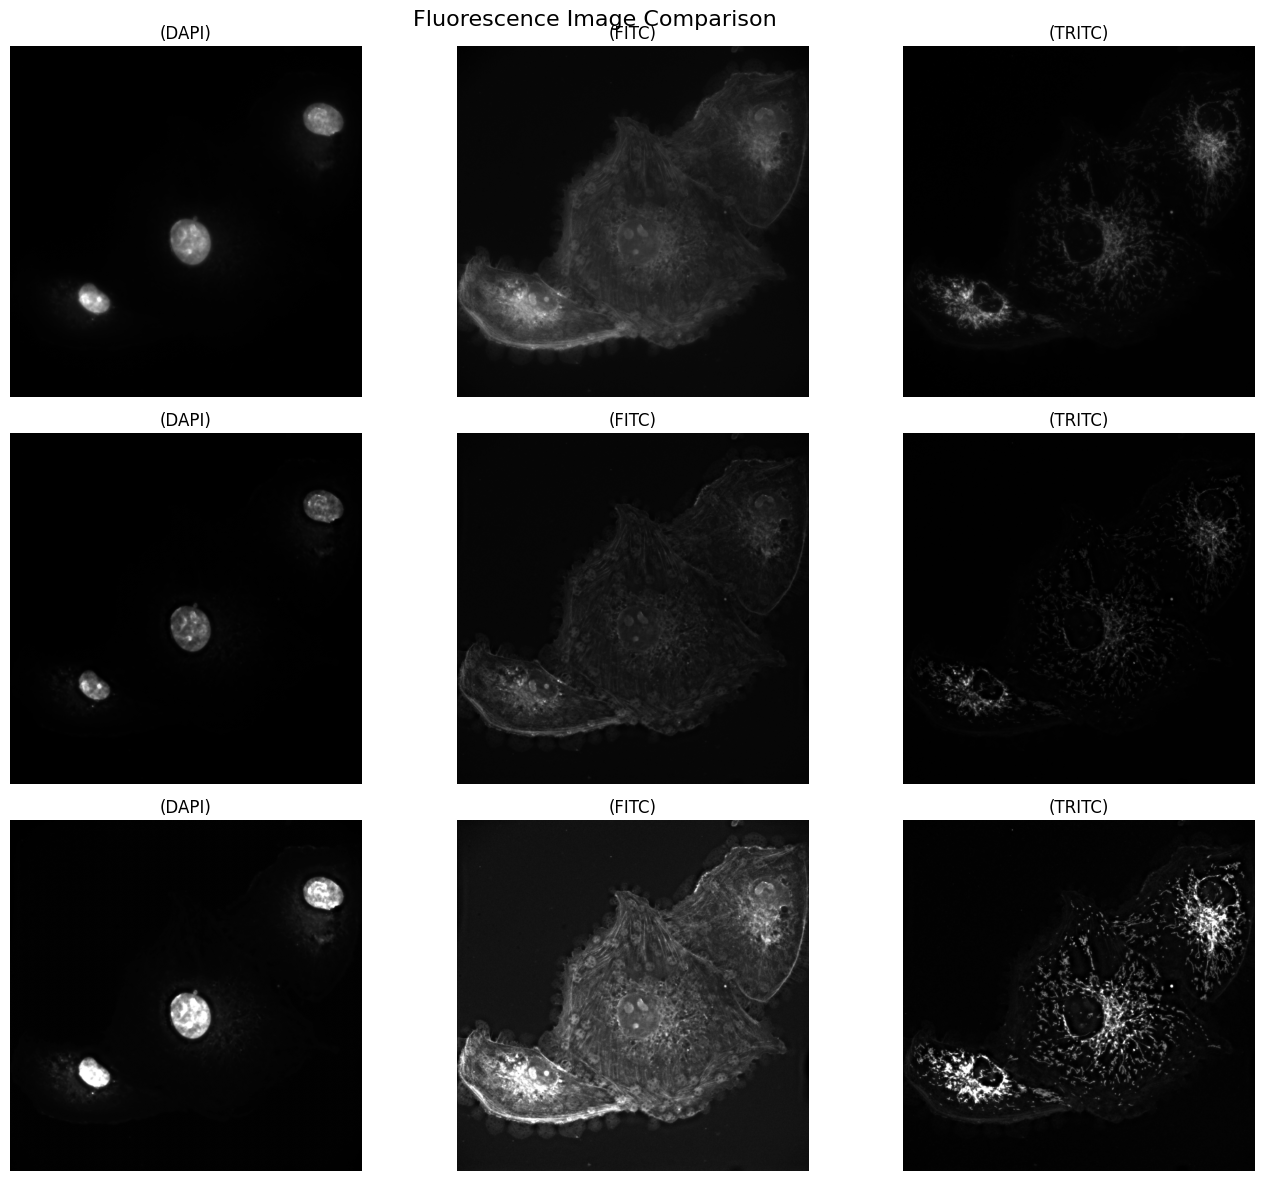

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# -------------------------- 0. Solve font display issues --------------------------
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# -------------------------- 1. Define file paths --------------------------
channel_names = ["(DAPI)", "(FITC)", "(TRITC)"]
image_paths = {
    # Row 0: Original images
    "raw": [
        "process_img\C1-Cell_4.ome.tif",
        "process_img\C2-Cell_4.ome.tif", 
        "process_img\C3-Cell_4.ome.tif"
    ],
    # Row 1: Deconvolved images
    "deconvolved": [
        "process_img\Final Display of RL_c1.tif",
        "process_img\Final Display of RL_c2.tif",
        "process_img\Final Display of RL_c3.tif"
    ],
    # Row 2: Contrast enhanced images
    "enhanced": [
        "process_img\Final Display of RL_c1_1.tif",
        "process_img\Final Display of RL_c2_1.tif",
        "process_img\Final Display of RL_c3_1.tif"
    ]
}

# -------------------------- 2. Fixed scale normalization function (65535→255) --------------------------
def normalize_16bit_gray_fixed_scale(img):
    """
    Fixed scale normalization: Map 16-bit full range (0-65535) to 8-bit (0-255) strictly
    Solve integer operation precision issues, adapt to fluorescence image display
    """
    # Ensure single channel
    if len(img.shape) == 3:
        img = img[:, :, 0]
    elif len(img.shape) != 2:
        raise ValueError("Image is not a valid 2D grayscale image")

    # Fixed 16-bit full range scale (0-65535 as you required)
    img_min = np.min(img)
    img_max = np.max(img)
    
    # Convert to float32 to avoid integer overflow/truncation (key optimization)
    img_float = img.astype(np.float32)
    # Fixed scale normalization
    normalized = (img_float - img_min) / (img_max - img_min) * 255
    # Clip to 0-255 to avoid out-of-bounds values
    normalized_clipped = np.clip(normalized, 0, 255)
    # Convert to 8-bit unsigned integer
    return normalized_clipped.astype(np.uint8)

# -------------------------- 3. Read and preprocess images --------------------------
images = {"raw": [], "deconvolved": [], "enhanced": []}

for process_type in ["raw", "deconvolved", "enhanced"]:
    for path in image_paths[process_type]:
        try:
            # Read 16-bit grayscale image
            img = np.array(Image.open(path))
            # Fixed scale normalization
            img_norm = normalize_16bit_gray_fixed_scale(img)
            images[process_type].append(img_norm)
        except FileNotFoundError:
            # Create blank image placeholder if file not found
            images[process_type].append(np.zeros((512, 512), dtype=np.uint8))
        except Exception as e:
            # Create blank image placeholder if error occurs
            images[process_type].append(np.zeros((512, 512), dtype=np.uint8))

# -------------------------- 4. Create 3x3 display layout --------------------------
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
row_titles = [
    "Original Image",
    "Deconvolved Image",
    "Contrast Enhanced Image"
]

# -------------------------- 5. Plot images --------------------------
for row_idx, (process_type, row_title) in enumerate(zip(["raw", "deconvolved", "enhanced"], row_titles)):
    for col_idx, (img, channel_name) in enumerate(zip(images[process_type], channel_names)):
        ax = axes[row_idx, col_idx]
        # Display grayscale image with fixed 0-255 scale
        ax.imshow(img, cmap='gray', vmin=0, vmax=255)
        # Set subplot title (channel name)
        ax.set_title(f"{channel_name}", fontsize=12, pad=5)
        # Hide axes
        ax.axis('off')
        # Set row title only for the first column of each row
        if col_idx == 0:
            ax.set_ylabel(row_title, fontsize=14, rotation=0, labelpad=40, va='center')

# Adjust subplot spacing to avoid title overlap
plt.tight_layout(rect=[0.05, 0.0, 1.0, 0.98])
# Add main title
fig.suptitle("Cell 4 Fluorescence Image Comparison", fontsize=16, y=0.98)

# Show image
plt.show()

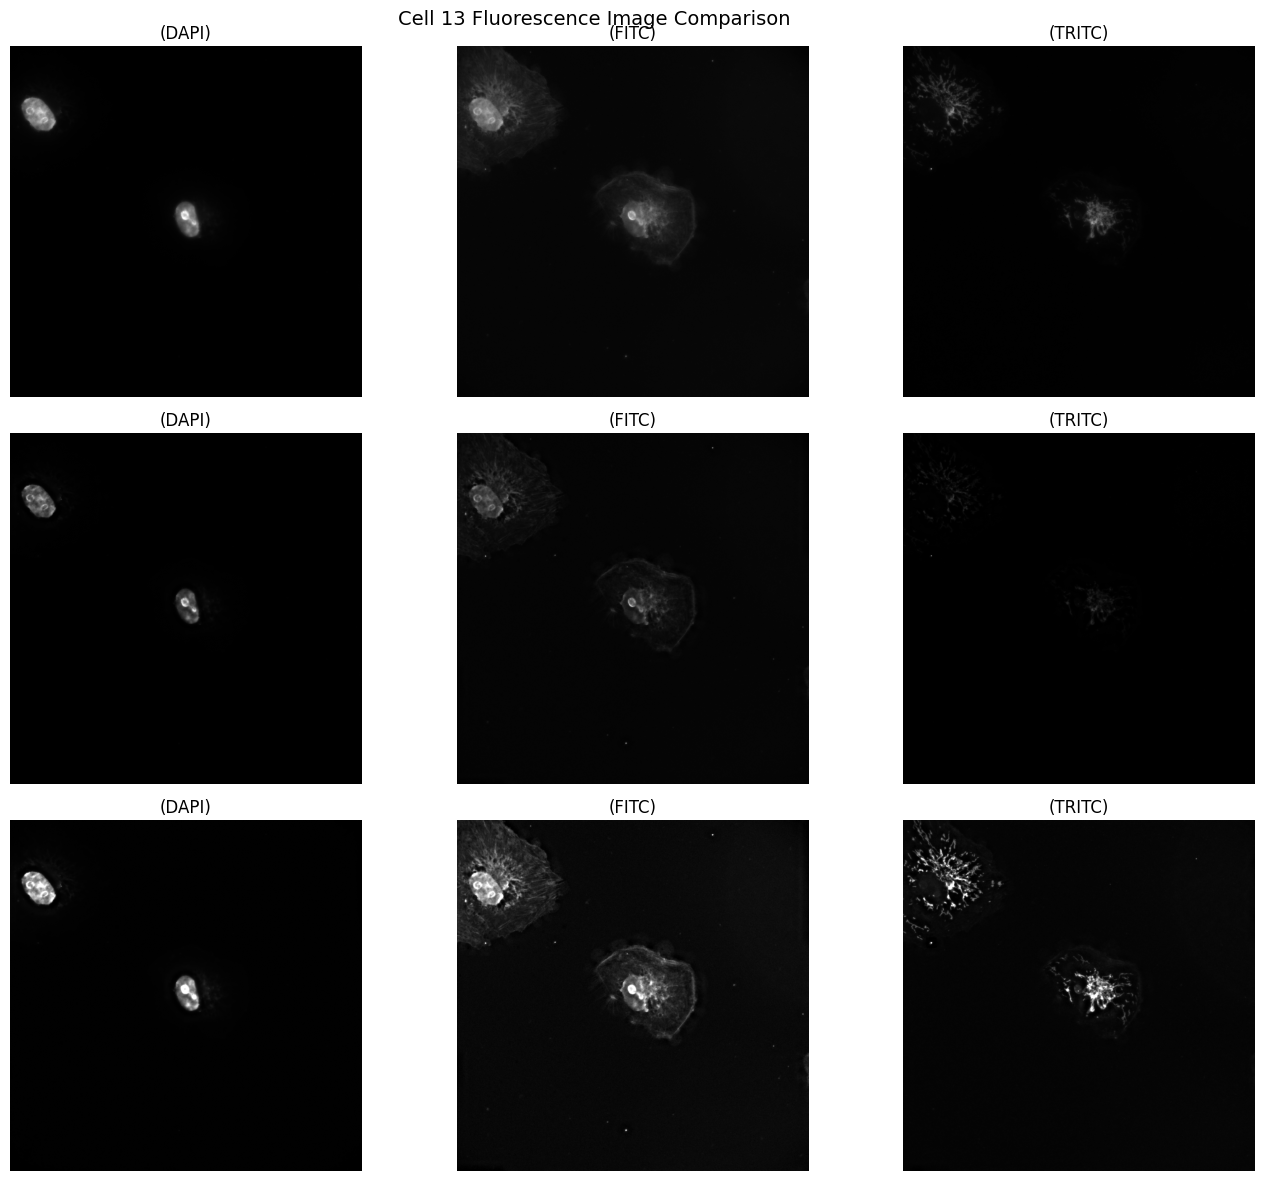

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# -------------------------- 0. Solve font display issues --------------------------
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# -------------------------- 1. Define file paths --------------------------
channel_names = ["(DAPI)", "(FITC)", "(TRITC)"]
image_paths = {
    # Row 0: Original images
    "raw": [
        "process_img_cell13\C1-Cell_13.ome.tif",
        "process_img_cell13\C2-Cell_13.ome.tif", 
        "process_img_cell13\C3-Cell_13.ome.tif"
    ],
    # Row 1: Deconvolved images
    "deconvolved": [
        "process_img_cell13\Final Display of RL_c1.tif",
        "process_img_cell13\Final Display of RL_c2.tif",
        "process_img_cell13\Final Display of RL_c3.tif"
    ],
    # Row 2: Contrast enhanced images
    "enhanced": [
        "process_img_cell13\Final Display of RL_c1_1.tif",
        "process_img_cell13\Final Display of RL_c2_1.tif",
        "process_img_cell13\Final Display of RL_c3_1.tif"
    ]
}

# -------------------------- 2. Fixed scale normalization function (65535→255) --------------------------
def normalize_16bit_gray_fixed_scale(img):
    """
    Fixed scale normalization: Map 16-bit full range (0-65535) to 8-bit (0-255) strictly
    Solve integer operation precision issues, adapt to fluorescence image display
    """
    # Ensure single channel
    if len(img.shape) == 3:
        img = img[:, :, 0]
    elif len(img.shape) != 2:
        raise ValueError("Image is not a valid 2D grayscale image")

    # Fixed 16-bit full range scale (0-65535 as you required)
    img_min = np.min(img)
    img_max = np.max(img)
    
    # Convert to float32 to avoid integer overflow/truncation (key optimization)
    img_float = img.astype(np.float32)
    # Fixed scale normalization
    normalized = (img_float - img_min) / (img_max - img_min) * 255
    # Clip to 0-255 to avoid out-of-bounds values
    normalized_clipped = np.clip(normalized, 0, 255)
    # Convert to 8-bit unsigned integer
    return normalized_clipped.astype(np.uint8)

# -------------------------- 3. Read and preprocess images --------------------------
images = {"raw": [], "deconvolved": [], "enhanced": []}

for process_type in ["raw", "deconvolved", "enhanced"]:
    for path in image_paths[process_type]:
        try:
            # Read 16-bit grayscale image
            img = np.array(Image.open(path))
            # Fixed scale normalization
            img_norm = normalize_16bit_gray_fixed_scale(img)
            images[process_type].append(img_norm)
        except FileNotFoundError:
            # Create blank image placeholder if file not found
            images[process_type].append(np.zeros((512, 512), dtype=np.uint8))
        except Exception as e:
            # Create blank image placeholder if error occurs
            images[process_type].append(np.zeros((512, 512), dtype=np.uint8))

# -------------------------- 4. Create 3x3 display layout --------------------------
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
row_titles = [
    "Original Image",
    "Deconvolved Image",
    "Contrast Enhanced Image"
]

# -------------------------- 5. Plot images --------------------------
for row_idx, (process_type, row_title) in enumerate(zip(["raw", "deconvolved", "enhanced"], row_titles)):
    for col_idx, (img, channel_name) in enumerate(zip(images[process_type], channel_names)):
        ax = axes[row_idx, col_idx]
        # Display grayscale image with fixed 0-255 scale
        ax.imshow(img, cmap='gray', vmin=0, vmax=255)
        # Set subplot title (channel name)
        ax.set_title(f"{channel_name}", fontsize=12, pad=5)
        # Hide axes
        ax.axis('off')
        # Set row title only for the first column of each row
        if col_idx == 0:
            ax.set_ylabel(row_title, fontsize=14, rotation=0, labelpad=40, va='center')

# Adjust subplot spacing to avoid title overlap
plt.tight_layout(rect=[0.05, 0.0, 1.0, 0.98])
# Add main title
fig.suptitle("Cell 13 Fluorescence Image Comparison", fontsize=14, y=0.98)

# Show image
plt.show()

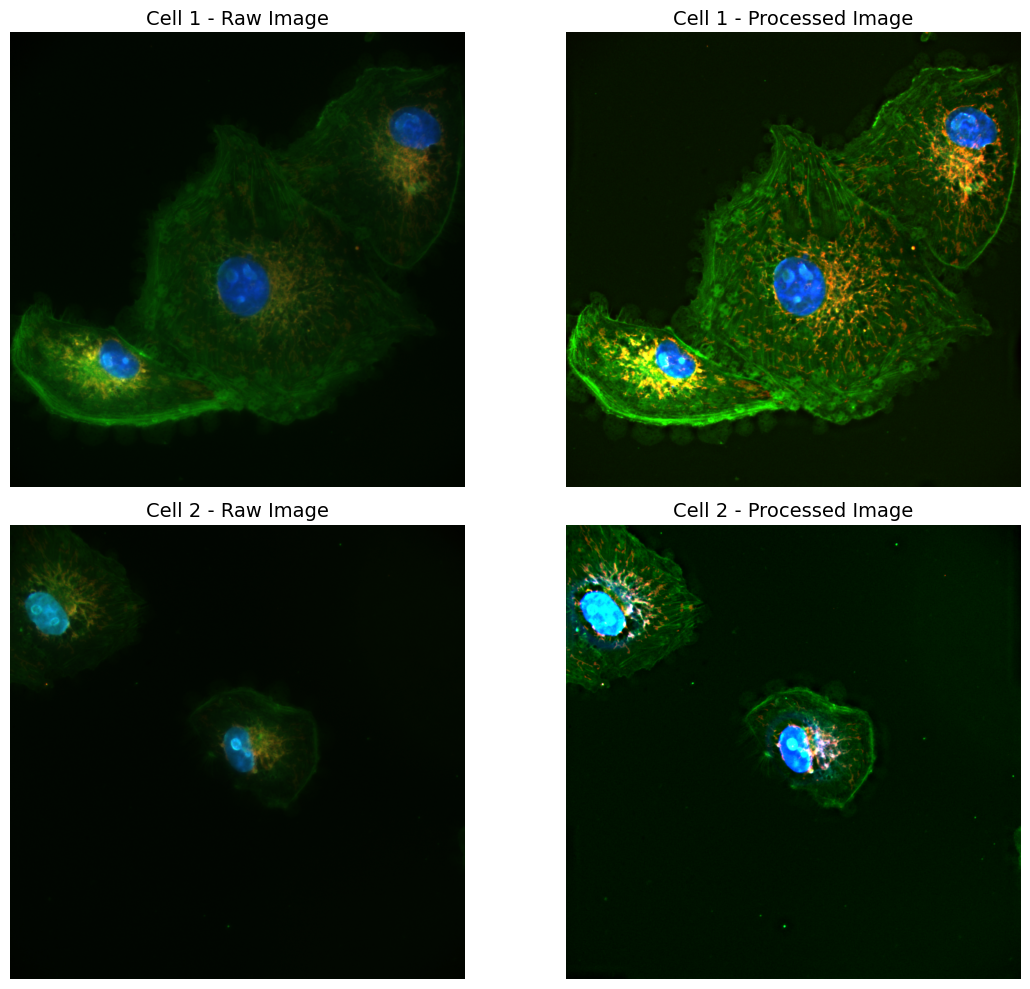

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


cell1_raw_path = "output\Cell_4_raw_rgb.tif"
cell1_enhanced_path = "output\Cell_4_enhanced_rgb.tif"
cell2_raw_path = "output\Cell_13_raw_rgb.tif"
cell2_enhanced_path = "output\Cell_13_enhanced_rgb.tif"

# 读取图像后转为numpy数组（解决部分PIL图像imshow不兼容问题）
cell1_raw = np.array(Image.open(cell1_raw_path))
cell1_enhanced = np.array(Image.open(cell1_enhanced_path))
cell2_raw = np.array(Image.open(cell2_raw_path))
cell2_enhanced = np.array(Image.open(cell2_enhanced_path))

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].imshow(cell1_raw)
axes[0, 0].set_title("Cell 4 - Raw Image", fontsize=14)
axes[0, 0].axis('off') 

axes[0, 1].imshow(cell1_enhanced)
axes[0, 1].set_title("Cell 4 - Processed Image", fontsize=14)
axes[0, 1].axis('off')

axes[1, 0].imshow(cell2_raw)
axes[1, 0].set_title("Cell 13 - Raw Image", fontsize=14)
axes[1, 0].axis('off')

axes[1, 1].imshow(cell2_enhanced)
axes[1, 1].set_title("Cell 13 - Processed Image", fontsize=14)
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()